In [1]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import resnet, vgg16, vgg19

# 預處理函數對照表
PREPROCESS_FN = {
    'VGG16': vgg16.preprocess_input,
    'VGG19': vgg19.preprocess_input,
    'ResNet50': resnet.preprocess_input,
    'ResNet101': resnet.preprocess_input,
    'ResNet152': resnet.preprocess_input,
}

2026-01-04 15:32:30.699452: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 15:32:30.756280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767511950.792544   99323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767511950.802089   99323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-04 15:32:30.894688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
IMG_FOLDER = '/mnt/f/course/computer_vision/final_proj_img/final_proj_img/pic/'
TXT_FOLDER = '/mnt/f/course/computer_vision/txt/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # 降低 batch size 以節省 GPU 記憶體

# 資料增強層
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

I0000 00:00:1767511954.578514   99323 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
def load_dataset_from_name_txt(img_folder, txt_folder):
    filename_list = []
    class_name_list = []
    
    # 1. 讀取 name.txt
    # 格式: "AncestorDinoArt_001.jpg AncestorDinoArt"
    name_txt_path = os.path.join(txt_folder, 'name.txt')
    print(f"Reading name.txt from: {name_txt_path}")
    
    with open(name_txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                filename_list.append(parts[0])      # e.g., AncestorDinoArt_001.jpg
                class_name_list.append(parts[1])    # e.g., AncestorDinoArt (這也是資料夾名稱)
    
    # 2. 建立標籤對照表
    unique_classes = sorted(list(set(class_name_list)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    print(f"Detected {len(unique_classes)} classes.")

    # 3. 讀取 query.txt (注意：這裡假設 query.txt 是 1-based index)
    query_txt_path = os.path.join(txt_folder, 'query.txt')
    with open(query_txt_path, 'r') as f:
        test_indices = set([int(line.strip()) - 1 for line in f])

    # 4. 分裝 Train / Test
    train_paths = []
    train_labels = []
    test_paths = []
    test_labels = []

    missing_count = 0

    for idx, filename in enumerate(filename_list):
        class_name = class_name_list[idx]
        
        # --- [關鍵修正] 路徑加入類別資料夾 ---
        # 舊路徑: pic/AncestorDinoArt_001.jpg (錯誤)
        # 新路徑: pic/AncestorDinoArt/AncestorDinoArt_001.jpg (正確)
        full_path = os.path.join(img_folder, class_name, filename)
        
        label_idx = class_to_idx[class_name]
        
        # 檢查檔案是否存在
        if not os.path.exists(full_path):
            if missing_count < 5: # 只印出前 5 個錯誤以免洗版
                print(f"Warning: File not found: {full_path}")
            missing_count += 1
            continue

        if idx in test_indices:
            test_paths.append(full_path)
            test_labels.append(label_idx)
        else:
            train_paths.append(full_path)
            train_labels.append(label_idx)

    if missing_count > 0:
        print(f"Total missing files: {missing_count}")
    else:
        print("All files found successfully!")

    return (train_paths, train_labels), (test_paths, test_labels), len(unique_classes)

# --- 執行讀取測試 ---
(tr_x, tr_y), (te_x, te_y), num_classes = load_dataset_from_name_txt(IMG_FOLDER, TXT_FOLDER)

print(f"Training Data: {len(tr_x)} images")
print(f"Testing Data: {len(te_x)} images")

# 建立 tf.data Pipeline (基礎預處理，不含模型特定預處理)
def preprocess_base(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    # 將標籤轉換為 one-hot 編碼
    label_onehot = tf.one_hot(label, depth=num_classes)
    return img, label_onehot

# 建立基礎資料集 (不做模型特定預處理，會在模型中處理)
train_paths_ds = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
train_ds_base = train_paths_ds.shuffle(buffer_size=len(tr_x)).map(preprocess_base, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_base = train_ds_base.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_paths_ds = tf.data.Dataset.from_tensor_slices((te_x, te_y))
test_ds_base = test_paths_ds.map(preprocess_base, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_base = test_ds_base.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Ready for ResNet/VGG training!")

Reading name.txt from: /mnt/f/course/computer_vision/txt/name.txt
Detected 50 classes.
Total missing files: 2
Training Data: 6999 images
Testing Data: 2999 images
Ready for ResNet/VGG training!


In [4]:
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, VGG16, VGG19
from tensorflow.keras import layers, models, Input

In [5]:
def build_model(model_name, fine_tune=False, fine_tune_at=0):
    """
    建構遷移學習模型
    
    Args:
        model_name: 模型名稱
        fine_tune: 是否進行 fine-tuning
        fine_tune_at: 從第幾層開始解凍 (0 = 全部凍結)
    """
    inputs = Input(shape=(224, 224, 3))
    
    # 資料增強 (只在訓練時套用)
    x = data_augmentation(inputs)
    
    # 套用模型特定的預處理
    preprocess_fn = PREPROCESS_FN[model_name]
    x = preprocess_fn(x)
    
    if model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'ResNet152':
        base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # 凍結 base model
    base_model.trainable = False
    
    # 如果要 fine-tune，解凍部分層
    if fine_tune and fine_tune_at > 0:
        base_model.trainable = True
        # 凍結 fine_tune_at 之前的層
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        print(f"Fine-tuning from layer {fine_tune_at}, total layers: {len(base_model.layers)}")
    
    x = base_model(x, training=False)  # training=False 確保 BN 層使用預訓練統計值
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # 增加 dropout 防止過擬合
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model, base_model


In [6]:
model_list = ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152']

# Fine-tune 起始層設定 (從這層開始解凍)
FINE_TUNE_LAYERS = {
    'VGG16': 15,      # VGG16 有 19 層，解凍最後 4 層
    'VGG19': 17,      # VGG19 有 22 層，解凍最後 5 層
    'ResNet50': 140,  # ResNet50 有 175 層，解凍最後 35 層
    'ResNet101': 300, # ResNet101 有 333 層，解凍最後 33 層
    'ResNet152': 480, # ResNet152 有 515 層，解凍最後 35 層
}

# 定義評估指標 (多分類問題使用 macro average)
def get_metrics():
    return [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc', multi_label=True),
        tf.keras.metrics.F1Score(name='f1_score', average='macro'),
    ]

history_dict = {}
results = {}
EPOCHS_PHASE1 = 20  # 第一階段：只訓練頂層
EPOCHS_PHASE2 = 30  # 第二階段：Fine-tuning

for model_name in model_list:
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    
    # ===== 第一階段：凍結 base model，只訓練頂層 =====
    print(f"\n[Phase 1] Training top layers only (frozen base model)")
    model, base_model = build_model(model_name, fine_tune=False)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=get_metrics()
    )
    
    callbacks_phase1 = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    history1 = model.fit(
        train_ds_base,
        epochs=EPOCHS_PHASE1,
        validation_data=test_ds_base,
        callbacks=callbacks_phase1
    )
    
    # ===== 第二階段：Fine-tuning =====
    print(f"\n[Phase 2] Fine-tuning from layer {FINE_TUNE_LAYERS[model_name]}")
    
    # 解凍部分 base model 層
    base_model.trainable = True
    fine_tune_at = FINE_TUNE_LAYERS[model_name]
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # 使用較低的學習率進行 fine-tuning
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 降低學習率
        loss='categorical_crossentropy',
        metrics=get_metrics()
    )
    
    callbacks_phase2 = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-7
        )
    ]
    
    history2 = model.fit(
        train_ds_base,
        epochs=EPOCHS_PHASE2,
        validation_data=test_ds_base,
        callbacks=callbacks_phase2
    )
    
    # 合併兩階段的 history
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    history_dict[model_name] = combined_history
    
    # 評估模型
    eval_results = model.evaluate(test_ds_base)
    # eval_results: [loss, accuracy, precision, recall, auc, f1_score]
    results[model_name] = {
        'accuracy': eval_results[1],
        'precision': eval_results[2],
        'recall': eval_results[3],
        'auc': eval_results[4],
        'f1_score': eval_results[5],
    }
    print(f"\n{model_name} Final Results:")
    print(f"  Accuracy:  {eval_results[1]:.4f}")
    print(f"  Precision: {eval_results[2]:.4f}")
    print(f"  Recall:    {eval_results[3]:.4f}")
    print(f"  AUC:       {eval_results[4]:.4f}")
    print(f"  F1 Score:  {eval_results[5]:.4f}")
    
    # 儲存模型
    model.save(f'/mnt/f/course/computer_vision/models/{model_name}_finetuned_0104.keras')
    print(f"Model saved to /mnt/f/course/computer_vision/models/{model_name}_finetuned_0104.keras")
    
    # 釋放記憶體
    del model, base_model
    tf.keras.backend.clear_session()
    
print("\n" + "="*60)
print("Training Complete!")
print("="*60)


Training VGG16

[Phase 1] Training top layers only (frozen base model)
Epoch 1/20


I0000 00:00:1767511984.162916   99423 cuda_dnn.cc:529] Loaded cuDNN version 90300
2026-01-04 15:33:05.128709: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


438/438 ━━━━━━━━━━━━━━━━━━━━ 58s 120ms/step - accuracy: 0.2676 - auc: 0.7702 - f1_score: 0.2607 - loss: 10.6664 - precision: 0.4813 - recall: 0.1610 - val_accuracy: 0.8273 - val_auc: 0.9908 - val_f1_score: 0.8189 - val_loss: 4.5541 - val_precision: 0.8880 - val_recall: 0.7716 - learning_rate: 0.0010
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step - accuracy: 0.6680 - auc: 0.9631 - f1_score: 0.6588 - loss: 4.6313 - precision: 0.8090 - recall: 0.5694 - val_accuracy: 0.8660 - val_auc: 0.9934 - val_f1_score: 0.8629 - val_loss: 2.7445 - val_precision: 0.9047 - val_recall: 0.8326 - learning_rate: 0.0010
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step - accuracy: 0.7426 - auc: 0.9750 - f1_score: 0.7317 - loss: 2.9445 - precision: 0.8334 - recall: 0.6565 - val_accuracy: 0.8843 - val_auc: 0.9938 - val_f1_score: 0.8834 - val_loss: 1.9896 - val_precision: 0.9208 - val_recall: 0.8456 - learning_rate: 0.0010
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - accuracy: 0.7522 - a

=== Model Comparison Results ===
           accuracy  precision  recall     auc  f1_score
VGG16        0.9486     0.9530  0.9456  0.9911    0.9488
VGG19        0.9550     0.9584  0.9520  0.9930    0.9551
ResNet50     0.9643     0.9700  0.9600  0.9968    0.9641
ResNet101    0.9690     0.9734  0.9653  0.9966    0.9692
ResNet152    0.9710     0.9738  0.9677  0.9966    0.9710


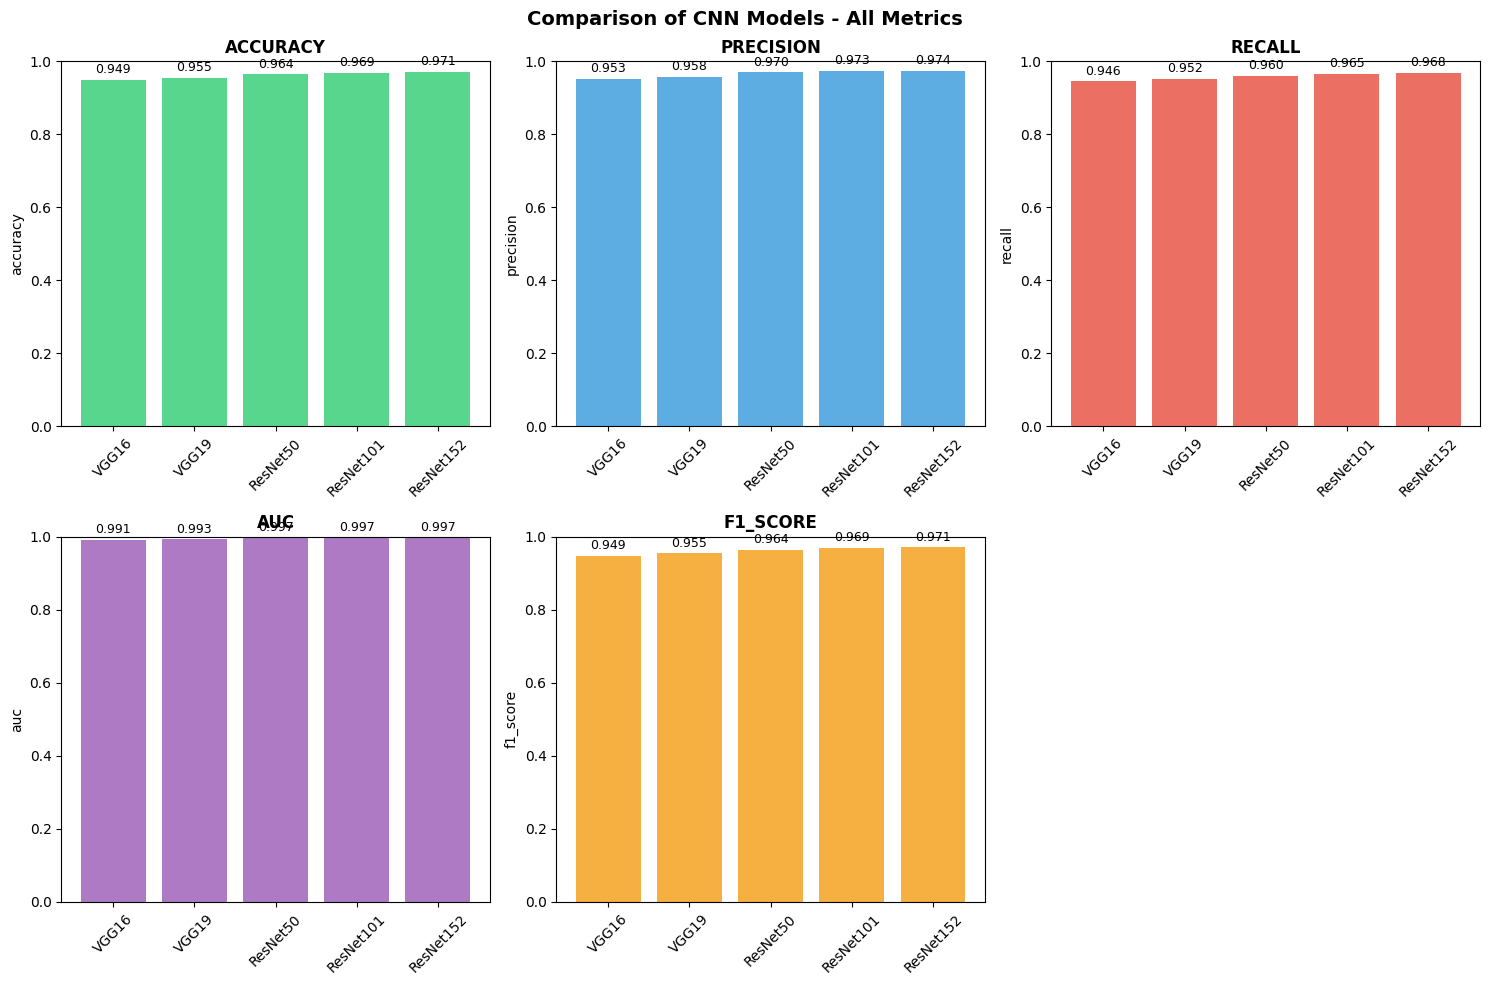

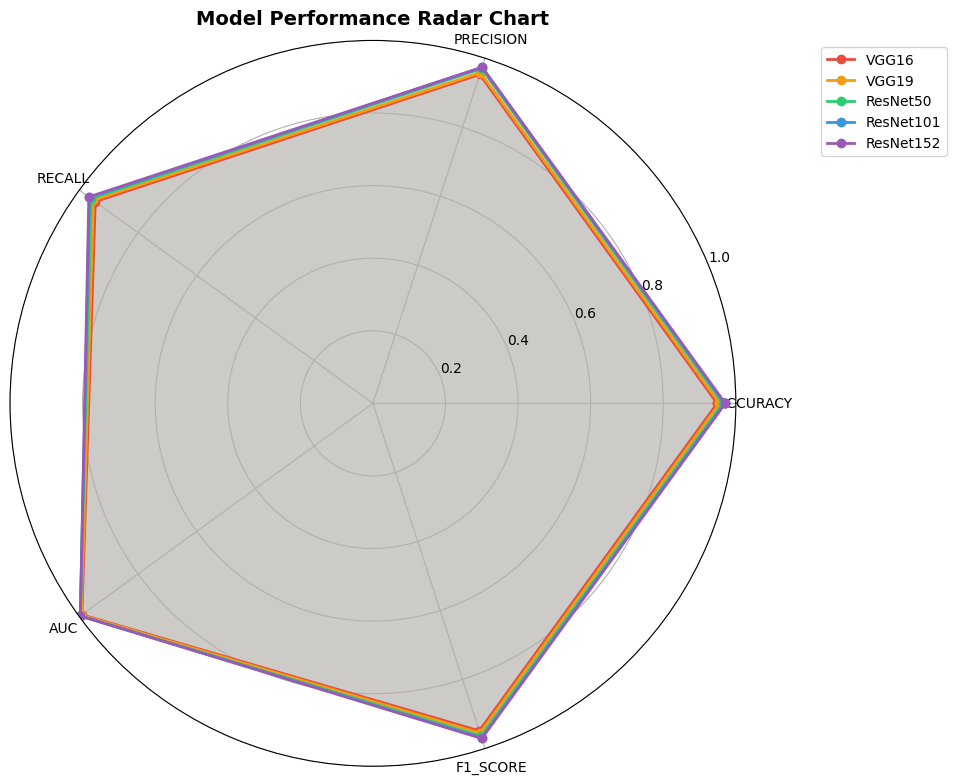

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# 將結果轉換為 DataFrame
df_results = pd.DataFrame(results).T
print("=== Model Comparison Results ===")
print(df_results.round(4))

# 繪製多指標比較圖
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'auc', 'f1_score']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = [results[model][metric] for model in results.keys()]
    bars = ax.bar(results.keys(), values, color=colors[idx], alpha=0.8)
    ax.set_ylim(0, 1.0)
    ax.set_title(f'{metric.upper()}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # 在長條圖上標示數值
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', 
                ha='center', va='bottom', fontsize=9)

# 隱藏多餘的子圖
axes[5].axis('off')

plt.suptitle('Comparison of CNN Models - All Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/guan/cuda_test/cv/models/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 繪製雷達圖比較
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 閉合多邊形

model_colors = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db', '#9b59b6']

for idx, model_name in enumerate(results.keys()):
    values = [results[model_name][m] for m in metrics]
    values += values[:1]  # 閉合多邊形
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=model_colors[idx])
    ax.fill(angles, values, alpha=0.1, color=model_colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([m.upper() for m in metrics])
ax.set_ylim(0, 1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.title('Model Performance Radar Chart', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/guan/cuda_test/cv/models/radar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()